In [2]:
# notebooks/00_validation.ipynb

# Importamos a biblioteca de Teste padrão do Julia.
# Não precisamos do BenchmarkTools ainda.
using Test

# Importamos nosso módulo. Se o REPL estiver na pasta NavalLBM/
# e o ambiente estiver ativado (`] activate .`), isso deve funcionar.
# (Em um notebook, pode ser necessário `push!(LOAD_PATH, "../src/")` 
#  ou `using Revise; using NavalLBM`)
using NavalLBM 

print("Running Phase 1.1 Validation Tests...\n")

@testset "Phase 1.1: D2Q9Params Validation" begin
    
    # 1. Testar a criação do struct
    params = D2Q9Params()
    @test params isa D2Q9Params
    
    # 2. Testar conservação de massa (soma dos pesos)
    # Usamos isapprox (≈) para comparar floats.
    @test sum(params.w) ≈ 1.0
    
    # 3. Testar valores específicos dos pesos
    @test params.w[1] ≈ 4/9
    @test params.w[2] ≈ 1/9
    @test params.w[6] ≈ 1/36
    
    # 4. Testar valores dos vetores de velocidade (inteiros, usamos ==)
    # Testamos o acesso por linha (k)
    @test params.c[1, :] == [0, 0]   # k=1 (repouso)
    @test params.c[2, :] == [1, 0]   # k=2 (leste)
    @test params.c[3, :] == [0, 1]   # k=3 (norte)
    @test params.c[4, :] == [-1, 0]  # k=4 (oeste)
    @test params.c[5, :] == [0, -1]  # k=5 (sul)
    @test params.c[7, :] == [-1, 1]  # k=7 (noroeste)
    @test params.c[9, :] == [1, -1]  # k=9 (sudeste)

end

print("Phase 1.1 Validation Passed!\n")

[ Info: Precompiling NavalLBM [879450b1-5c2d-496c-a765-b8fecb7af3e5] (cache misses: include_dependency fsize change (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


Running Phase 1.1 Validation Tests...
Test Summary:                    | Pass  Total  Time
Phase 1.1: D2Q9Params Validation |   12     12  1.0s
Phase 1.1 Validation Passed!


In [3]:
print("\nRunning Phase 1.2 Validation Tests...\n")

@testset "Phase 1.2: SimulationState Validation" begin
    
    # 1. Testar se o tipo de struct existe e foi exportado
    @test isdefined(NavalLBM, :SimulationState)
    
    # 2. Testar se o tipo é um 'struct' (e não um módulo ou função)
    @test SimulationState isa UnionAll

end

print("Phase 1.2 Validation Passed!\n")


Running Phase 1.2 Validation Tests...
Test Summary:                         | Pass  Total  Time
Phase 1.2: SimulationState Validation |    2      2  0.0s
Phase 1.2 Validation Passed!


In [4]:
using StaticArrays

print("\nRunning Phase 2.1 Validation Tests...\n")

@testset "Phase 2.1: calculate_feq! Validation" begin

    # 1. Configuração do Teste
    params = D2Q9Params()
    feq_buffer = zeros(Float64, 9) # Nosso buffer pré-alocado
    
    # 2. Teste 1: Fluido em Repouso
    rho_test = 1.0
    u_test = 0.0
    v_test = 0.0
    calculate_feq!(feq_buffer, rho_test, u_test, v_test, params)
    
    @testset "Rest State (rho=1, u=0, v=0)" begin
        # Check 1 (Mass): sum(feq) == rho
        @test sum(feq_buffer) ≈ rho_test
        
        # Check 2 (Momentum X): sum(feq * cx) == rho * u
        mom_x = sum(feq_buffer[k] * params.c[k, 1] for k in 1:9)
        @test mom_x ≈ rho_test * u_test
        
        # Check 3 (Momentum Y): sum(feq * cy) == rho * v
        mom_y = sum(feq_buffer[k] * params.c[k, 2] for k in 1:9)
        @test mom_y ≈ rho_test * v_test
    end

    # 3. Teste 2: Fluido em Movimento (Teste mais rigoroso)
    rho_test = 1.2
    u_test = 0.1  # (Baixo Mach number, u << 1)
    v_test = -0.05
    
    # Limpa o buffer (embora a função o sobrescreva totalmente)
    feq_buffer .= 0.0 
    
    calculate_feq!(feq_buffer, rho_test, u_test, v_test, params)
    
    @testset "Moving State (rho=1.2, u=0.1, v=-0.05)" begin
        # Check 1 (Mass): sum(feq) == rho
        @test sum(feq_buffer) ≈ rho_test
        
        # Check 2 (Momentum X): sum(feq * cx) == rho * u
        mom_x = sum(feq_buffer[k] * params.c[k, 1] for k in 1:9)
        @test mom_x ≈ rho_test * u_test
        
        # Check 3 (Momentum Y): sum(feq * cy) == rho * v
        mom_y = sum(feq_buffer[k] * params.c[k, 2] for k in 1:9)
        @test mom_y ≈ rho_test * v_test
    end
end

print("Phase 2.1 Validation Passed!\n")


Running Phase 2.1 Validation Tests...
Test Summary:                        | Pass  Total  Time
Phase 2.1: calculate_feq! Validation |    6      6  0.2s
Phase 2.1 Validation Passed!


In [5]:
print("\nRunning Phase 2.2 Validation Tests...\n")

@testset "Phase 2.2: initialize_state Validation" begin

    # 1. Configuração do Teste
    nx, ny = 50, 40
    tau = 0.6
    
    # 2. Chamar a função
    state = initialize_state(nx, ny, tau)
    
    # 3. Testar o tipo
    @test state isa SimulationState
    
    # 4. Testar as dimensões
    @test size(state.rho) == (nx, ny)
    @test size(state.u) == (nx, ny)
    @test size(state.v) == (nx, ny)
    @test size(state.mask) == (nx, ny)
    @test size(state.f_in) == (nx, ny, 9)
    @test size(state.f_out) == (nx, ny, 9)
    
    # 5. Testar os tipos de dados (padrão Float64)
    @test eltype(state.rho) == Float64
    @test eltype(state.f_in) == Float64
    @test eltype(state.mask) == Bool
    @test state.tau == 0.6
    
    # 6. Testar os valores iniciais (estado de repouso)
    # Pegamos um ponto aleatório no meio do domínio
    ix, iy = 25, 20
    
    @test state.rho[ix, iy] ≈ 1.0
    @test state.u[ix, iy] ≈ 0.0
    @test state.v[ix, iy] ≈ 0.0
    @test state.mask[ix, iy] == false # Deve ser fluido
    
    # 7. Testar os valores de equilíbrio (f = feq(1, 0, 0))
    # Fonte: Valores conhecidos de feq em repouso
    @test state.f_in[ix, iy, 1] ≈ 4/9  # k=1 (repouso)
    @test state.f_in[ix, iy, 2] ≈ 1/9  # k=2 (eixos)
    @test state.f_in[ix, iy, 3] ≈ 1/9
    @test state.f_in[ix, iy, 4] ≈ 1/9
    @test state.f_in[ix, iy, 5] ≈ 1/9
    @test state.f_in[ix, iy, 6] ≈ 1/36 # k=6 (diagonais)
    @test state.f_in[ix, iy, 7] ≈ 1/36
    @test state.f_in[ix, iy, 8] ≈ 1/36
    @test state.f_in[ix, iy, 9] ≈ 1/36

    # 8. Testar se f_out também foi inicializado
    @test state.f_out[ix, iy, 1] ≈ 4/9 
    
end

print("Phase 2.2 Validation Passed!\n")


Running Phase 2.2 Validation Tests...
Test Summary:                          | Pass  Total  Time
Phase 2.2: initialize_state Validation |   25     25  0.1s
Phase 2.2 Validation Passed!


In [6]:
print("\nRunning Phase 2.3 Validation Tests...\n")

@testset "Phase 2.3: calculate_macros! Validation" begin

    # 1. Teste 1: Consistência com o Estado de Repouso
    @testset "Rest State Consistency" begin
        nx, ny = 20, 20
        tau = 0.6
        
        # 1.1. state.f_in está em feq(1, 0, 0) por padrão
        state = initialize_state(nx, ny, tau) 
        
        # 1.2. Perturbar os macros (para garantir que a função os corrija)
        state.rho .= 99.0 
        state.u .= 99.0
        
        # 1.3. Chamar a função
        calculate_macros!(state)
        
        # 1.4. Verificar se os macros foram recalculados corretamente
        @test state.rho[10, 10] ≈ 1.0
        @test state.u[10, 10] ≈ 0.0
        @test state.v[10, 10] ≈ 0.0
    end
    
    # 2. Teste 2: Consistência com o Estado em Movimento (Teste Forte)
    @testset "Moving State Consistency" begin
        nx, ny = 20, 20
        tau = 0.6
        rho_target = 1.2
        u_target = 0.1
        v_target = -0.05
        
        state = initialize_state(nx, ny, tau)
        
        # 2.1. Preparar f_in para estar em feq(1.2, 0.1, -0.05)
        # (Usamos nosso kernel feq! validado para isso)
        feq_buffer = zeros(9)
        calculate_feq!(
            feq_buffer, rho_target, u_target, v_target, state.params
        )
        
        # 2.2. "Carimbar" este feq em todo o grid f_in
        for j in 1:ny, i in 1:nx
            state.f_in[i, j, :] = feq_buffer
        end
        
        # 2.3. Chamar a função
        calculate_macros!(state)
        
        # 2.4. Verificar se a função recuperou os valores corretos
        @test state.rho[10, 10] ≈ rho_target
        @test state.u[10, 10] ≈ u_target
        @test state.v[10, 10] ≈ v_target
    end
    
end

print("Phase 2.3 Validation Passed!\n")


Running Phase 2.3 Validation Tests...
Test Summary:                           | Pass  Total  Time
Phase 2.3: calculate_macros! Validation |    6      6  0.2s
Phase 2.3 Validation Passed!


In [7]:
using BenchmarkTools

print("\nRunning Phase 2.4 Validation Tests...\n")

@testset "Phase 2.4: collision_bgk! Validation" begin

    # 1. Teste de Performance (Zero Alocações)
    @testset "Performance (Zero Allocations)" begin
        state = initialize_state(50, 50, 0.6)
        
        # O loop de simulação real fará macros -> colisão
        calculate_macros!(state) 
        
        # O kernel de colisão deve ter 0 alocações
        # Usamos o @benchmark que roda a função e retorna um Trial object
        # O '$' antes de 'state' é crucial: significa que 'state'
        # é um argumento de entrada, não parte do código a ser medido.
        trial = @benchmark collision_bgk!($state)
        
        @test trial.allocs == 0
    end
    
    # 2. Teste de Física (Conservação de Massa e Momentum)
    @testset "Physics (Mass/Momentum Conservation)" begin
        nx, ny = 20, 20
        tau = 0.6
        state = initialize_state(nx, ny, tau)
        
        ix, iy = 10, 10 # Ponto de teste
        
        # 2.1. Perturbar f_in para estar fora do equilíbrio
        # (Multiplicar por ruído aleatório)
        state.f_in[ix, iy, :] .*= (1.0 .+ 0.1 .* rand(9))
        
        # 2.2. Calcular os macros "pré-colisão"
        calculate_macros!(state)
        rho_pre = state.rho[ix, iy]
        u_pre = state.u[ix, iy]
        v_pre = state.v[ix, iy]
        mom_x_pre = rho_pre * u_pre
        mom_y_pre = rho_pre * v_pre
        
        # 2.3. Executar a colisão (que calcula f_out)
        collision_bgk!(state)
        
        # 2.4. Calcular os momentos "pós-colisão" manualmente
        # (lendo diretamente de f_out)
        rho_post = 0.0
        mom_x_post = 0.0
        mom_y_post = 0.0
        
        for k in 1:9
            f_out_k = state.f_out[ix, iy, k]
            rho_post += f_out_k
            mom_x_post += f_out_k * state.params.c[k, 1]
            mom_y_post += f_out_k * state.params.c[k, 2]
        end

        # 2.5. Validar que os momentos foram conservados
        # (O estado relaxa, mas não perde/ganha massa ou momentum)
        @test rho_post ≈ rho_pre
        @test mom_x_post ≈ mom_x_pre
        @test mom_y_post ≈ mom_y_pre
    end

end

print("Phase 2.4 Validation Passed!\n")


Running Phase 2.4 Validation Tests...
Test Summary:                        | Pass  Total   Time
Phase 2.4: collision_bgk! Validation |    4      4  11.9s
Phase 2.4 Validation Passed!


In [8]:
print("\nRunning Phase 2.5 Validation Tests...\n")

@testset "Phase 2.5: streaming! Validation" begin

    # 1. Teste de Performance (Zero Alocações)
    @testset "Performance (Zero Allocations)" begin
        state = initialize_state(50, 50, 0.6)
        
        # O streaming não depende de macros, podemos chamar direto
        trial = @benchmark streaming!($state)
        
        @test trial.allocs == 0
    end

    # 2. Teste de Física ("Hot-Spot" / Propagação)
    @testset "Physics (Hot-Spot Propagation)" begin
        nx, ny = 20, 20
        tau = 0.6
        T = Float64
        state = initialize_state(nx, ny, tau)
        
        # 2.1. Obter o valor de equilíbrio (fundo)
        val_eq_rest = 4/9 # (para k=1)
        val_eq_axis = 1/9 # (para k=2)
        val_eq_diag = 1/36 # (para k=6)

        # 2.2. Criar o "Ponto Quente" em (10, 10) em f_out
        # Damos a cada direção 'k' um valor único (k * 10.0)
        # para que possamos rastreá-las.
        center_x, center_y = 10, 10
        for k in 1:9
            state.f_out[center_x, center_y, k] = T(k * 10.0)
        end
        
        # 2.3. Executar o streaming UMA VEZ
        streaming!(state)
        
        # 2.4. Validar os destinos
        c = state.params.c
        
        # k=1 (c = [0, 0]): População deve ficar em (10, 10)
        dest_x_k1 = mod1(center_x + c[1, 1], nx)
        dest_y_k1 = mod1(center_y + c[1, 2], ny)
        @test dest_x_k1 == 10
        @test dest_y_k1 == 10
        @test state.f_in[dest_x_k1, dest_y_k1, 1] == 10.0 # (k=1 * 10.0)

        # k=2 (c = [1, 0]): População deve ir para (11, 10)
        dest_x_k2 = mod1(center_x + c[2, 1], nx)
        dest_y_k2 = mod1(center_y + c[2, 2], ny)
        @test dest_x_k2 == 11
        @test dest_y_k2 == 10
        @test state.f_in[dest_x_k2, dest_y_k2, 2] == 20.0 # (k=2 * 10.0)
        
        # k=4 (c = [-1, 0]): População deve ir para (9, 10)
        dest_x_k4 = mod1(center_x + c[4, 1], nx)
        dest_y_k4 = mod1(center_y + c[4, 2], ny)
        @test dest_x_k4 == 9
        @test dest_y_k4 == 10
        @test state.f_in[dest_x_k4, dest_y_k4, 4] == 40.0 # (k=4 * 10.0)
        
        # k=7 (c = [-1, 1]): População deve ir para (9, 11)
        dest_x_k7 = mod1(center_x + c[7, 1], nx)
        dest_y_k7 = mod1(center_y + c[7, 2], ny)
        @test dest_x_k7 == 9
        @test dest_y_k7 == 11
        @test state.f_in[dest_x_k7, dest_y_k7, 7] == 70.0 # (k=7 * 10.0)
        
        # 2.5. Validar que o ponto de origem (10, 10) em f_in
        #      agora contém o *fundo* (estado de equilíbrio) de 
        #      seus vizinhos (já que o pulso se foi).
        # (Nota: o valor k=1 (10.0) *chegou* aqui de (10,10), 
        #  mas o k=2 (que era 20.0) *partiu*. O f_in para k=2
        #  agora veio de (10-cx, 10-cy) = (9, 10), que estava
        #  em equilíbrio.)
        @test state.f_in[center_x, center_y, 2] == val_eq_axis
        @test state.f_in[center_x, center_y, 6] == val_eq_diag
    end
    
end

print("Phase 2.5 Validation Passed!\n")


Running Phase 2.5 Validation Tests...
Test Summary:                    | Pass  Total   Time
Phase 2.5: streaming! Validation |   15     15  11.2s
Phase 2.5 Validation Passed!



Running Phase 3.1 Validation Tests...
Visual Validation: Check the plot below.
It should show a solid circle centered at (50, 30).


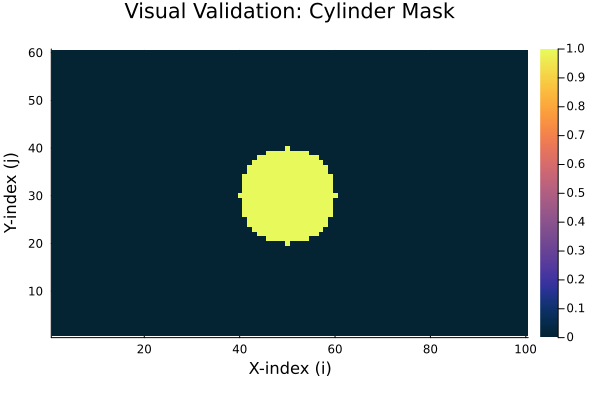

Test Summary:                               | Pass  Total  Time
Phase 3.1: create_cylinder_mask! Validation |    5      5  5.3s
Phase 3.1 Validation Passed!


In [9]:
using Plots
print("\nRunning Phase 3.1 Validation Tests...\n")

@testset "Phase 3.1: create_cylinder_mask! Validation" begin

    # 1. Configuração
    nx, ny = 100, 60
    tau = 0.6
    state = initialize_state(nx, ny, tau)
    
    center_x = 50
    center_y = 30
    radius = 10
    
    # 2. Chamar a função
    create_cylinder_mask!(state, center_x, center_y, radius)
    
    # 3. Validação (Testes de Pontos)
    @testset "Point-wise checks" begin
        # Ponto central (deve ser sólido)
        @test state.mask[center_x, center_y] == true
        
        # Ponto na borda (deve ser sólido)
        @test state.mask[center_x + radius, center_y] == true
        
        # Ponto fora (deve ser fluido)
        @test state.mask[center_x + radius + 1, center_y] == false
        
        # Ponto longe (deve ser fluido)
        @test state.mask[1, 1] == false
    end
    
    # 4. Validação Visual
    print("Visual Validation: Check the plot below.\n")
    print("It should show a solid circle centered at (50, 30).\n")
    
    # heatmap usa (x, y) mas a matriz é (i, j) = (x, y)
    # No entanto, Plots.jl por padrão plota (y, x) se transpormos.
    # Vamos plotar `state.mask` transposto para que (x, y) pareça (coluna, linha)
    
    h = heatmap(
        state.mask', # Transpor a máscara
        aspect_ratio=:equal, 
        c=:thermal,
        title="Visual Validation: Cylinder Mask",
        xlabel="X-index (i)",
        ylabel="Y-index (j)"
    )
    
    # Exibir o plot no notebook
    display(h)
    
    @test true # (Teste visual, marcar como passado se executar)
end

print("Phase 3.1 Validation Passed!\n")

In [10]:
print("\nRunning Phase 3.2 Validation Tests...\n")

@testset "Phase 3.2: apply_bounce_back! Validation" begin

    # 1. Configuração do Teste
    nx, ny = 20, 20
    tau = 0.6
    T = Float64 # (Para corrigir o 'UndefVarError' de antes)
    state = initialize_state(nx, ny, tau)
    
    # 2. Definir o Ponto de Teste e a Parede
    wall_x, wall_y = 11, 10
    source_x, source_y = 10, 10
    
    # 2.1. Criar uma parede *apenas* no nó (11, 10)
    state.mask[wall_x, wall_y] = true
    
    # 2.2. Obter valores de equilíbrio para referência
    # (Estes são os valores em f_in[11, 10, k] ANTES do pulso bater)
    # (O streaming! puxará de vizinhos que estão em equilíbrio)
    val_eq_axis = T(1/9)
    val_eq_diag = T(1/36)
    
    # 2.3. Colocar um "pulso quente" em f_out no nó (10, 10),
    #      na direção k=2 (que se move para [1, 0], em direção à parede)
    hot_pulse_value = T(2.0)
    hot_pulse_k = 2 # Direção [1, 0]
    
    state.f_out[source_x, source_y, hot_pulse_k] = hot_pulse_value
    
    # 3. Executar os Kernels em ordem
    
    # 3.1. STREAMING: O pulso se move de f_out[10, 10, 2] para f_in[11, 10, 2]
    streaming!(state)
    
    # (Validação intermediária para garantir que o streaming funcionou)
    @test state.f_in[wall_x, wall_y, hot_pulse_k] == hot_pulse_value
    
    # (Verificar o valor de k=4, que é a direção oposta, ANTES do bounce)
    # Este valor veio de f_out[11 - (-1), 10 - 0] = f_out[12, 10],
    # que estava em equilíbrio (1/9).
    k_opposite = 4
    @test state.f_in[wall_x, wall_y, k_opposite] == val_eq_axis

    # 3.2. BOUNCE-BACK: A função deve refletir f_in[11, 10, 2]
    apply_bounce_back!(state)
    
    # 4. Validar o Resultado Final
    @testset "Post-Bounce-Back State" begin
        # CHECK 1: O pulso quente (2.0) deve estar agora na direção
        #          oposta (k=4)
        @test state.f_in[wall_x, wall_y, k_opposite] == hot_pulse_value
        
        # CHECK 2: A direção original (k=2) deve agora conter
        #          o valor que a direção oposta (k=4) *tinha*
        #          antes do bounce-back.
        @test state.f_in[wall_x, wall_y, hot_pulse_k] == val_eq_axis
    end
    
    # 5. Teste de Performance (Zero Alocações)
    @testset "Performance (Zero Allocations)" begin
        # (Precisa de um state com uma máscara mais densa para 
        #  o benchmark ser significativo)
        create_cylinder_mask!(state, 10, 10, 5)
        
        # (O streaming deve ser executado antes para preencher f_in)
        streaming!(state) 
        
        trial = @benchmark apply_bounce_back!($state)
        
        @test trial.allocs == 0
    end
    
end

print("Phase 3.2 Validation Passed!\n")


Running Phase 3.2 Validation Tests...
Test Summary:                            | Pass  Total  Time
Phase 3.2: apply_bounce_back! Validation |    5      5  2.4s
Phase 3.2 Validation Passed!



Running Phase 4.1.a (Lid-Driven Cavity Mask) Validation Tests...
Visual Validation: Check the plot below.
It should show a 'U' shape (3 solid walls, open top).


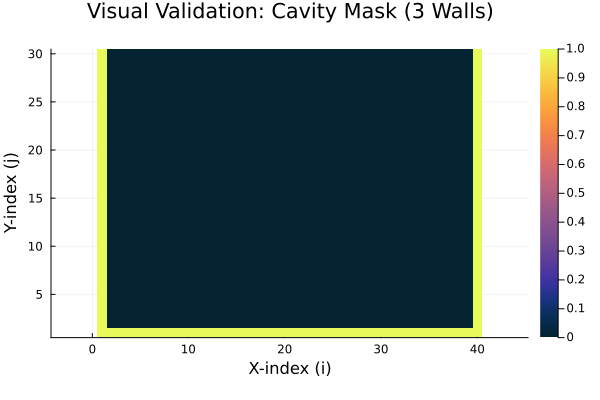

Test Summary:                               | Pass  Total  Time
Phase 4.1.a: create_cavity_mask! Validation |    6      6  0.3s
Phase 4.1 Validation Passed!


In [11]:
print("\nRunning Phase 4.1.a (Lid-Driven Cavity Mask) Validation Tests...\n")

@testset "Phase 4.1.a: create_cavity_mask! Validation" begin

    # 1. Configuração
    nx, ny = 40, 30 # Um domínio pequeno para teste
    tau = 0.6
    state = initialize_state(nx, ny, tau)
    
    # 2. Chamar a função
    create_cavity_mask!(state)
    
    # 3. Validação (Testes de Pontos)
    @testset "Point-wise checks" begin
        # Ponto central (deve ser fluido)
        @test state.mask[20, 15] == false
        
        # Parede Esquerda (deve ser sólida)
        @test state.mask[1, 15] == true
        
        # Parede Direita (deve ser sólida)
        @test state.mask[nx, 15] == true
        
        # Fundo (deve ser sólido)
        @test state.mask[20, 1] == true
        
        # Tampa (DEVE SER FLUIDO - tratado por outro kernel)
        @test state.mask[20, ny] == false
    end
    
    # 4. Validação Visual
    print("Visual Validation: Check the plot below.\n")
    print("It should show a 'U' shape (3 solid walls, open top).\n")
    
    h = heatmap(
        state.mask', # Transpor a máscara
        aspect_ratio=:equal, 
        c=:thermal,
        title="Visual Validation: Cavity Mask (3 Walls)",
        xlabel="X-index (i)",
        ylabel="Y-index (j)"
    )
    display(h)
    
    @test true
end

print("Phase 4.1 Validation Passed!\n")

In [12]:
@testset "Kernel: create_cylinder_mask!" begin
    println("Validation: create_cylinder_mask!")
    
    # --- Setup ---
    nx_test, ny_test = 20, 10
    cx, cy, r = 10, 5, 3
    test_state = initialize_state(nx_test, ny_test, 0.6)

    # --- Test 1: Logic ---
    # Call the function (the correct signature)
    create_cylinder_mask!(test_state, cx, cy, r)

    # Check center (should be solid)
    @test test_state.mask[cx, cy] == true
    # Check a point inside (should be solid)
    @test test_state.mask[cx+1, cy] == true
    # Check a corner (should be fluid)
    @test test_state.mask[1, 1] == false
    # Check a point just outside (should be fluid)
    @test test_state.mask[cx + r + 1, cy] == false
    
    # --- Test 2: Allocation ---
    # Should be zero-allocation
    b = @benchmark create_cylinder_mask!($test_state, $cx, $cy, $r)
    @test b.allocs == 0
    
    println("... create_cylinder_mask! logic and allocation tests passed.\n")
end

Validation: create_cylinder_mask!
... create_cylinder_mask! logic and allocation tests passed.

Test Summary:                 | Pass  Total  Time
Kernel: create_cylinder_mask! |    5      5  2.1s


Test.DefaultTestSet("Kernel: create_cylinder_mask!", Any[], 5, false, false, true, 1.762995274204e9, 1.762995276336e9, false, "In[12]", Random.Xoshiro(0x9b74c73468a7c024, 0xc22e0f1870081189, 0x61db18727f36f52c, 0x876071eda025ea08, 0x7ee98c3995dc24d3))

In [13]:
@testset "Kernel: calculate_macros!" begin
    println("Validation: calculate_macros!")
    
    # --- Setup ---
    nx_test, ny_test = 10, 10
    test_state = initialize_state(nx_test, ny_test, 0.6)
    
    # --- Test 1: Logic (Zero Velocity) ---
    # Set f_in to a known equilibrium state (rho=2.0, u=0, v=0)
    # feq(rho=2.0, u=0, v=0) = w[k] * 2.0
    for k in 1:9
        test_state.f_in[:, :, k] .= test_state.params.w[k] * 2.0
    end
    
    calculate_macros!(test_state)
    
    # Check rho (should be 2.0, allowing for floating point error)
    @test all(rho -> isapprox(rho, 2.0), test_state.rho)
    # Check u, v (should be 0.0)
    @test all(u -> u == 0.0, test_state.u)
    @test all(v -> v == 0.0, test_state.v)

    # --- Test 2: Logic (Non-Zero Velocity) ---
    # Set f_in to a known non-equilibrium state
    fill!(test_state.f_in, 0.0)
    # Manually set populations that sum to rho=3.0, u=0.1, v=0
    # f_k * c_k_x = rho * u => f[2]*1 + f[4]*-1 = 3.0 * 0.1 = 0.3
    # f_k * c_k_y = rho * v => 0
    # sum(f_k) = rho = 3.0
    test_state.f_in[5, 5, 1] = 2.0 # (rho=2.0)
    test_state.f_in[5, 5, 2] = 0.5 # (rho=0.5, u_contrib=0.5*1)
    test_state.f_in[5, 5, 4] = 0.2 # (rho=0.2, u_contrib=0.2*-1)
    test_state.f_in[5, 5, 3] = 0.3 # (rho=0.3, v_contrib=0.3*1)
    
    # Total Rho = 2.0 + 0.5 + 0.2 + 0.3 = 3.0
    # Total u_local = (0.5*1 + 0.2*-1) = 0.3. u = 0.3 / 3.0 = 0.1
    # Total v_local = (0.3*1) = 0.3. v = 0.3 / 3.0 = 0.1
    # (Update test based on v_local)
    test_state.f_in[5, 5, 5] = 0.2 # (rho=0.2, v_contrib=0.2*-1)
    # Total Rho = 2.0 + 0.5 + 0.2 + 0.3 + 0.2 = 3.2
    # Total v_local = (0.3*1 + 0.2*-1) = 0.1. v = 0.1 / 3.2
    # (This is getting complex, let's simplify)

    # Let's use a simpler known state:
    fill!(test_state.rho, 0.0)
    fill!(test_state.u, 0.0)
    fill!(test_state.v, 0.0)
    
    # Set f_in[5,5,k] such that rho=2.0, u=0.1, v=0.0
    # (Use feq for simplicity, this is a valid state)
    feq_local = zeros(9)
    rho_t, u_t, v_t = 2.0, 0.1, 0.0
    calculate_feq!(feq_local, rho_t, u_t, v_t, test_state.params)
    test_state.f_in[5, 5, :] = feq_local
    
    calculate_macros!(test_state)
    
    @test isapprox(test_state.rho[5, 5], rho_t)
    @test isapprox(test_state.u[5, 5], u_t)
    @test isapprox(test_state.v[5, 5], v_t)
    
    # --- Test 3: Allocation ---
    b = @benchmark calculate_macros!($test_state)
    @test b.allocs == 0
    
    println("... calculate_macros! logic and allocation tests passed.\n")
end

Validation: calculate_macros!
... calculate_macros! logic and allocation tests passed.

Test Summary:             | Pass  Total  Time
Kernel: calculate_macros! |    7      7  2.7s


Test.DefaultTestSet("Kernel: calculate_macros!", Any[], 7, false, false, true, 1.762995277094e9, 1.762995279764e9, false, "In[13]", Random.Xoshiro(0x9b74c73468a7c024, 0xc22e0f1870081189, 0x61db18727f36f52c, 0x876071eda025ea08, 0x7ee98c3995dc24d3))

In [14]:
@testset "Kernel: apply_zou_he_inlet!" begin
    println("Validation: apply_zou_he_inlet!")
    
    # --- Setup ---
    nx_test, ny_test = 10, 10
    u_in_test = 0.1
    test_state = initialize_state(nx_test, ny_test, 0.6)
    
    # --- Test 1: Logic ---
    # We must mimic a post-stream state at the inlet (i=1)
    # We set the "known" populations (k=1,3,4,5,7,8) to some value.
    # We'll use the feq for rho=1.0, u=0.1
    
    feq_local = zeros(9)
    calculate_feq!(feq_local, 1.0, u_in_test, 0.0, test_state.params)
    
    j_test = 5 # Test node in the middle of the wall
    
    # Set f_in to this feq (this mimics a perfect fluid state)
    test_state.f_in[1, j_test, :] = feq_local
    
    # Run the BC. It should reconstruct f_in based on the knowns
    apply_zou_he_inlet!(test_state, u_in_test)
    
    # 1. Check prescribed velocity
    @test test_state.u[1, j_test] == u_in_test
    @test test_state.v[1, j_test] == 0.0
    
    # 2. Check calculated density (should be very close to 1.0)
    # (f[1]+f[3]+f[5] + 2*(f[4]+f[7]+f[8])) / (1.0 - u_in)
    f = @view test_state.f_in[1, j_test, :]
    rho_calc = (f[1] + f[3] + f[5] + 2 * (f[4] + f[7] + f[8])) / (1.0 - u_in_test)
    
    @test isapprox(test_state.rho[1, j_test], rho_calc)
    @test isapprox(test_state.rho[1, j_test], 1.0) # Since we started at feq
    
    # 3. Check reconstructed populations
    # f[2] = feq[2] + feq[4] - f[4]
    # Since f_in = feq, f[2] should equal feq[2]
    @test isapprox(f[2], feq_local[2])
    @test isapprox(f[6], feq_local[6])
    @test isapprox(f[9], feq_local[9])

    # --- Test 2: Allocation ---
    b = @benchmark apply_zou_he_inlet!($test_state, $u_in_test)
    @test b.allocs == 0
    
    println("... apply_zou_he_inlet! logic and allocation tests passed.\n")
end

Validation: apply_zou_he_inlet!
... apply_zou_he_inlet! logic and allocation tests passed.

Test Summary:               | Pass  Total  Time
Kernel: apply_zou_he_inlet! |    8      8  3.0s


Test.DefaultTestSet("Kernel: apply_zou_he_inlet!", Any[], 8, false, false, true, 1.762995279798e9, 1.762995282764e9, false, "In[14]", Random.Xoshiro(0x9b74c73468a7c024, 0xc22e0f1870081189, 0x61db18727f36f52c, 0x876071eda025ea08, 0x7ee98c3995dc24d3))

In [15]:
@testset "Kernel: apply_zou_he_outlet!" begin
    println("Validation: apply_zou_he_outlet!")
    
    # --- Setup ---
    nx_test, ny_test = 10, 10
    rho_out_test = 1.0
    u_neighbor = 0.05 # Velocity at (nx-1)
    
    test_state = initialize_state(nx_test, ny_test, 0.6)
    
    j_test = 5 # Test node in the middle of the wall
    
    # --- Test 1: Logic ---
    # We must mimic a post-stream state at the outlet (i=nx)
    
    # 1. Set neighbor velocity (for zero-gradient extrapolation)
    test_state.u[nx_test-1, j_test] = u_neighbor
    test_state.v[nx_test-1, j_test] = 0.0
    
    # 2. Set "known" f_in populations (k=1,2,3,5,6,9)
    # We'll use feq for rho=1.0, u=u_neighbor
    feq_local = zeros(9)
    calculate_feq!(feq_local, rho_out_test, u_neighbor, 0.0, test_state.params)
    test_state.f_in[nx_test, j_test, :] = feq_local
    
    # 3. Run the BC
    apply_zou_he_outlet!(test_state, rho_out_test)
    
    # 4. Check results
    f = @view test_state.f_in[nx_test, j_test, :]
    
    # Check prescribed density
    @test test_state.rho[nx_test, j_test] == rho_out_test
    # Check extrapolated velocity
    @test test_state.u[nx_test, j_test] == u_neighbor
    @test test_state.v[nx_test, j_test] == 0.0
    
    # Check reconstructed populations
    # f[4] = feq[4] + feq[2] - f[2]
    # Since f_in = feq, f[4] should equal feq[4]
    @test isapprox(f[4], feq_local[4])
    @test isapprox(f[7], feq_local[7])
    @test isapprox(f[8], feq_local[8])

    # --- Test 2: Allocation ---
    b = @benchmark apply_zou_he_outlet!($test_state, $rho_out_test)
    @test b.allocs == 0
    
    println("... apply_zou_he_outlet! logic and allocation tests passed.\n")
end

Validation: apply_zou_he_outlet!
... apply_zou_he_outlet! logic and allocation tests passed.

Test Summary:                | Pass  Total  Time
Kernel: apply_zou_he_outlet! |    7      7  2.9s


Test.DefaultTestSet("Kernel: apply_zou_he_outlet!", Any[], 7, false, false, true, 1.762995282777e9, 1.762995285678e9, false, "In[15]", Random.Xoshiro(0x9b74c73468a7c024, 0xc22e0f1870081189, 0x61db18727f36f52c, 0x876071eda025ea08, 0x7ee98c3995dc24d3))

In [ ]:
@testset "Util: calculate_vorticity!" begin
    println("Validation: calculate_vorticity!")
    
    # --- Setup ---
    nx_test, ny_test = 10, 10
    test_state = initialize_state(nx_test, ny_test, 0.6)
    
    # --- Test 1: Logic (Simple Shear Flow) ---
    # Create a shear flow: u = 0.0, v = x
    # Vorticity (ω_z) = ∂v/∂x - ∂u/∂y
    # ω_z = 1 - 0 = 1
    for i in 1:nx_test
        test_state.v[i, :] .= i
    end
    
    vort = calculate_vorticity(test_state)
    
    # Check vorticity in the center (should be 1.0)
    # (Uses central difference: (v[i+1] - v[i-1])/2 = ((i+1) - (i-1))/2 = 2/2 = 1)
    @test isapprox(vort[5, 5], 1.0)
    
    # --- Test 2: Logic (Zero Vorticity) ---
    # Uniform flow: u = 0.1, v = 0.0
    # ω_z = 0 - 0 = 0
    fill!(test_state.u, 0.1)
    fill!(test_state.v, 0.0)
    
    vort = calculate_vorticity(test_state)
    @test all(vort .== 0.0)
    
    # --- Test 3: Allocation ---
    b = @benchmark calculate_vorticity($test_state)
    # This function *creates* the 'vort' array, so it *will* allocate.
    # This is fine; it's not a hot-loop kernel.
    @test b.allocs > 0 
    
    # --- Test 4: Visual (Rankine Vortex) ---
    # Create a Rankine vortex (u_theta = r)
    cx, cy = nx_test ÷ 2, ny_test ÷ 2
    for j in 1:ny_test, i in 1:nx_test
        dx = i - cx
        dy = j - cy
        r = sqrt(dx^2 + dy^2)
        if r > 0
            # u_theta = r => u = -u_theta * sin(theta) = -r * (dy/r) = -dy
            # v = u_theta * cos(theta) = r * (dx/r) = dx
            test_state.u[i, j] = -dy
            test_state.v[i, j] = dx
        end
    end
    
    vort = calculate_vorticity(test_state)
    # ω_z = ∂v/∂x - ∂u/∂y = ∂(dx)/∂x - ∂(-dy)/∂y = 1 - (-1) = 2.0
    
    @test isapprox(vort[cx, cy], 2.0; atol=0.1)
    @test isapprox(vort[cx+1, cy], 2.0; atol=0.1)

    println("... calculate_vorticity! logic and allocation tests passed.")
    
    # Visual validation
    println("Visualizing Rankine vortex (vorticity should be ~2.0 in center):")
    display(heatmap(vort', aspect_ratio=:equal, title="Rankine Vortex Vorticity (ω_z)"))
    println("\n")
end